In [1]:
from IPython.core.display import display, HTML

HTML(
    '''
    <script>
        code_show = false; 
        
        function code_toggle() {
            if (code_show){
                $('div.input').hide();
            } else {
                $('div.input').show();
            }
                code_show = !code_show
            }
            
        $( document ).ready(code_toggle);
    </script>
    
    <form action="javascript:code_toggle()">
        <input type="submit" value="Show code">
    </form>
    '''
)

<a id='index'></a>
# Multi-objective problem example

With constraints

* [Input data](#input_data)
    * [GA parameters](#ga_params)
    * [Start date](#start_date)
    * [Product data](#product_data)
    * [Changeovers](#changeovers)
    * [Demand](#demand)
    * [Inventory target](#inventory_target)
* [Multi-objective problem](#mo_problem)
    * [Pareto front](#pareto_front)
    * [Soltution X](#solution_x)
        * [Objectives](#objectives)
        * [Inventory levels](#inventory)
        * [Campaigns gantt](#campaigns_gantt)
        * [Campaigns table](#campaigns_table)
        * [Batches table](#batches_table)
        * [Tasks gantt](#tasks_gantt)
        * [Tasks table](#tasks_table)
    * [Soltution Y](#solution_y)
        * [Objectives](#objectives_y)
        * [Inventory levels](#inventory_y)
        * [Campaigns gantt](#campaigns_gantt_y)
        * [Campaigns table](#campaigns_table_y)
        * [Batches table](#batches_table_y)
        * [Tasks gantt](#tasks_gantt_y)
        * [Tasks table](#tasks_table_y)

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

import plotly.offline as opy
import plotly.graph_objs as go
opy.init_notebook_mode()

import utils
from biopharma_scheduling.single_site import DeterministicSingleSite

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
if not os.path.exists('figures'):
    os.mkdir('figures')
    
colors = {
    'A': 'rgb(146, 208, 80)', 
    'B': 'rgb(179, 129, 217)', 
    'C': 'rgb(196, 189, 151)', 
    'D': 'rgb(255, 0, 0)'
}

def interactive_chart(df, colors: dict=None, title=''):
    data = [
        go.Scatter(
            x=df.index,
            y=df[product],
            name=product,
            marker=dict(
                color=colors[product]
            ) if colors else None,
            mode='lines+markers'
        ) for product in df
    ]

    layout = go.Layout(
        title=title,
        xaxis={
            'tickangle': -30,
        },
        yaxis={'title': 'Kg'}
    )

    return opy.iplot(go.Figure(data=go.Data(data), layout=layout))

<a id='input_data'></a>
## Input data

[back to top](#index)

In [5]:
# How the input data is stored doesn't matter as long as Pandas DataFrames are used in the end
start_date = '2016-12-01'
kg_demand = pd.read_csv('data/kg_demand.csv', index_col='date')
kg_inventory_target = pd.read_csv('data/kg_inventory_target.csv', index_col='date')
product_data = pd.read_csv('data/product_data.csv')
changeover_days = pd.read_csv('data/changeover_days.csv')

display(HTML('<a id="ga_params"></a>'))
display(HTML('<h3>GA parameters</h3>'))
ga_params = pd.DataFrame(np.transpose([
    [20], 
    [400], 
    [1000], 
    [1], 
    [0.820769],
    [0.141214], 
    [0.121224], 
    [0.213939], 
    [0.766782]
]), columns=[
    'num_runs',
    'popsize',
    'num_gens', 
    'starting_length',
    'p_xo', 
    'p_product_mut',
    'p_plus_batch_mut',
    'p_minus_batch_mut',
    'p_gene_swap'
], index=['value'])
display(ga_params.transpose())
display(HTML('<a href=#index>back to top</a>'))

display(HTML('<a id="start_date"></a>'))
display(HTML('<h3>Schedule start date</h3>'))
display(HTML('<h4>%s</h4>' % start_date))
display(HTML('<a href=#index>back to top</a>'))

display(HTML('<a id="product_data"></a>'))
display(HTML('<h3>Product data</h3>'))
product_data.kg_storage_limits = [250, 250, 250, 250]
product_data.shelf_life_days = [730, 730, 730, 730]
product_data.kg_opening_stock = [18.6, 0, 19.6, 32.0]
product_data.min_batches_per_campaign = [2, 2, 2, 3]
product_data.max_batches_per_campaign = [50, 50, 50, 30]
product_data.batches_multiples_of_per_campaign = [1, 1, 1, 3]
display(product_data.transpose())
display(HTML('<a href=#index>back to top</a>'))

display(HTML('<a id="changeovers"></a>'))
display(HTML('<h3>Product-dependent changeover data [days]</h3>'))
display(changeover_days)
display(HTML('<a href=#index>back to top</a>'))

display(HTML('<a id="demand"></a>'))
display(HTML('<h3>Product demand [kg]</h3>'))
display(kg_demand.transpose())
interactive_chart(kg_demand, colors)
display(HTML('<a href=#index>back to top</a>'))

display(HTML('<a id="inventory_target"></a>'))
display(HTML('<h3>Product inventory target [kg]</h3>'))
display(kg_inventory_target.transpose())
interactive_chart(kg_inventory_target, colors)
display(HTML('<a href=#index>back to top</a>'))

value
num_runs             20.000000
popsize             400.000000
num_gens           1000.000000
starting_length       1.000000
p_xo                  0.820769
p_product_mut         0.141214
p_plus_batch_mut      0.121224
p_minus_batch_mut     0.213939
p_gene_swap           0.766782

0    1     2    3
product                               A    B     C    D
inoculation_days                     20   15    20   26
seed_days                            11    7    11    9
production_days                      14   14    14   14
usp_days                             45   36    45   49
dsp_days                              7   11     7    7
approval_days                        90   90    90   90
shelf_life_days                     730  730   730  730
kg_yield_per_batch                  3.1  6.2   4.9  5.5
kg_storage_limits                   250  250   250  250
kg_opening_stock                   18.6    0  19.6   32
min_batches_per_campaign              2    2     2    3
max_batches_per_campaign             50   50    50   30
batches_multiples_of_per_campaign     1    1     1    3
production_cost_per_kg                1    1     1    1
sell_price_per_kg                     1    1     1    1
inventory_penalty_per_kg              1    1     1    1
backlog_penalty_per_kg                1    1     1    1
storage_cost_per_kg                   1    1     1    1
waste_cost_per_kg                     1    1     1    1

product   A   B   C   D
0       A   0  10  16  20
1       B  16   0  16  20
2       C  16  10   0  20
3       D  18  10  18   0

date  2017-01-01  2017-02-01  2017-03-01  2017-04-01  2017-05-01  2017-06-01  \
A            0.0         0.0         3.1         0.0         0.0         3.1   
B            0.0         0.0         0.0         0.0         0.0         0.0   
C            0.0         0.0         0.0         0.0         0.0         0.0   
D            0.0         5.5         5.5         0.0         5.5         5.5   

date  2017-07-01  2017-08-01  2017-09-01  2017-10-01  2017-11-01  2017-12-01  \
A            0.0         3.1         3.1         3.1         0.0         6.2   
B            0.0         0.0         0.0         0.0         0.0         0.0   
C            4.9         4.9         0.0         0.0         0.0         9.8   
D            5.5         5.5         5.5         0.0        11.0         5.5   

date  2018-01-01  2018-02-01  2018-03-01  2018-04-01  2018-05-01  2018-06-01  \
A            6.2         3.1         6.2         0.0         3.1         9.3   
B            0.0         0.0         0.0         0.0         0.0         0.0   
C            4.9         0.0         4.9         0.0         0.0         4.9   
D            0.0         5.5         5.5        11.0         5.5         5.5   

date  2018-07-01  2018-08-01  2018-09-01  2018-10-01  2018-11-01  2018-12-01  \
A            0.0         6.2         6.2         0.0         6.2         9.3   
B            0.0         0.0         0.0         0.0         6.2         0.0   
C            9.8         0.0         0.0         0.0         4.9         4.9   
D            0.0         5.5         5.5         5.5        11.0         5.5   

date  2019-01-01  2019-02-01  2019-03-01  2019-04-01  2019-05-01  2019-06-01  \
A            0.0         9.3         6.2         3.1         6.2         3.1   
B            0.0         0.0         0.0         0.0         6.2         0.0   
C            0.0         9.8         0.0         0.0         4.9         9.8   
D            0.0        11.0         0.0        11.0         5.5         5.5   

date  2019-07-01  2019-08-01  2019-09-01  2019-10-01  2019-11-01  2019-12-01  
A            0.0         9.3         6.2         9.3         6.2         0.0  
B            0.0         0.0         0.0         0.0         0.0         6.2  
C            9.8         0.0         4.9         9.8         4.9         0.0  
D            0.0        11.0        11.0         0.0         5.5         5.5

date  2017-01-01  2017-02-01  2017-03-01  2017-04-01  2017-05-01  2017-06-01  \
A            6.2         6.2         9.3         9.3        12.4        12.4   
B            0.0         0.0         0.0         0.0         0.0         0.0   
C            0.0         4.9         9.8         9.8         9.8         9.8   
D           22.0        27.5        27.5        27.5        27.5        33.0   

date  2017-07-01  2017-08-01  2017-09-01  2017-10-01  2017-11-01  2017-12-01  \
A           15.5        21.7        21.7        24.8        21.7        24.8   
B            0.0         0.0         0.0         0.0         0.0         0.0   
C           19.6        19.6        14.7        19.6        19.6        19.6   
D           33.0        27.5        27.5        27.5        38.5        33.0   

date  2018-01-01  2018-02-01  2018-03-01  2018-04-01  2018-05-01  2018-06-01  \
A           27.9        21.7        24.8        24.8        24.8        27.9   
B            0.0         0.0         0.0         0.0         0.0         6.2   
C           14.7        19.6        19.6        14.7        14.7        19.6   
D           33.0        33.0        33.0        33.0        27.5        33.0   

date  2018-07-01  2018-08-01  2018-09-01  2018-10-01  2018-11-01  2018-12-01  \
A           27.9        27.9        31.0        31.0        34.1        34.1   
B            6.2         6.2         6.2         6.2         6.2         6.2   
C           19.6         9.8        19.6        19.6        19.6        19.6   
D           33.0        33.0        38.5        33.0        38.5        33.0   

date  2019-01-01  2019-02-01  2019-03-01  2019-04-01  2019-05-01  2019-06-01  \
A           27.9        27.9        27.9        27.9        34.1        34.1   
B            6.2         6.2         6.2         6.2         6.2         6.2   
C           24.5        34.3        24.5        29.4        39.2        39.2   
D           33.0        33.0        33.0        44.0        33.0        33.0   

date  2019-07-01  2019-08-01  2019-09-01  2019-10-01  2019-11-01  2019-12-01  
A           31.0        31.0        21.7        15.5         6.2         0.0  
B            6.2         6.2         6.2         6.2         6.2         6.2  
C           29.4        19.6        19.6        14.7         4.9         0.0  
D           33.0        33.0        22.0        11.0        11.0         5.5

<a id='mo_problem'></a>
## Multi-objective problem

* Objectives:
    * Minimise ***total kg inventory deficit***
    * Maximise ***total kg throughput***
<br><br>
* Constraints:
    * Keep ***total kg backlog*** at 0 kg
    * Keep ***total kg waste*** at 0 kg

[back to top](#index)

In [6]:
objectives = {
    'total_kg_inventory_deficit': -1, # min
    'total_kg_throughput': 1 # max
}

constraints = {
    'total_kg_backlog': [-1, 0], # <= 0
    'total_kg_waste': [-1, 0] # <= 0
}

model = DeterministicSingleSite(
    num_runs=ga_params.num_runs[0],
    num_gens=ga_params.num_gens[0],
    popsize=ga_params.popsize[0],
    starting_length=ga_params.starting_length[0],
    p_xo=ga_params.p_xo[0],
    p_product_mut=ga_params.p_product_mut[0],
    p_plus_batch_mut=ga_params.p_plus_batch_mut[0],
    p_minus_batch_mut=ga_params.p_minus_batch_mut[0],
    p_gene_swap=ga_params.p_gene_swap[0],
    random_state=7, 
    num_threads=-1, 
    verbose=True
).fit(
    start_date,
    objectives,
    kg_demand,
    product_data,
    changeover_days,
    kg_inventory_target,
    constraints
)

Done: 100%|██████████| 20000/20000 [03:01<00:00, 110.20it/s]                


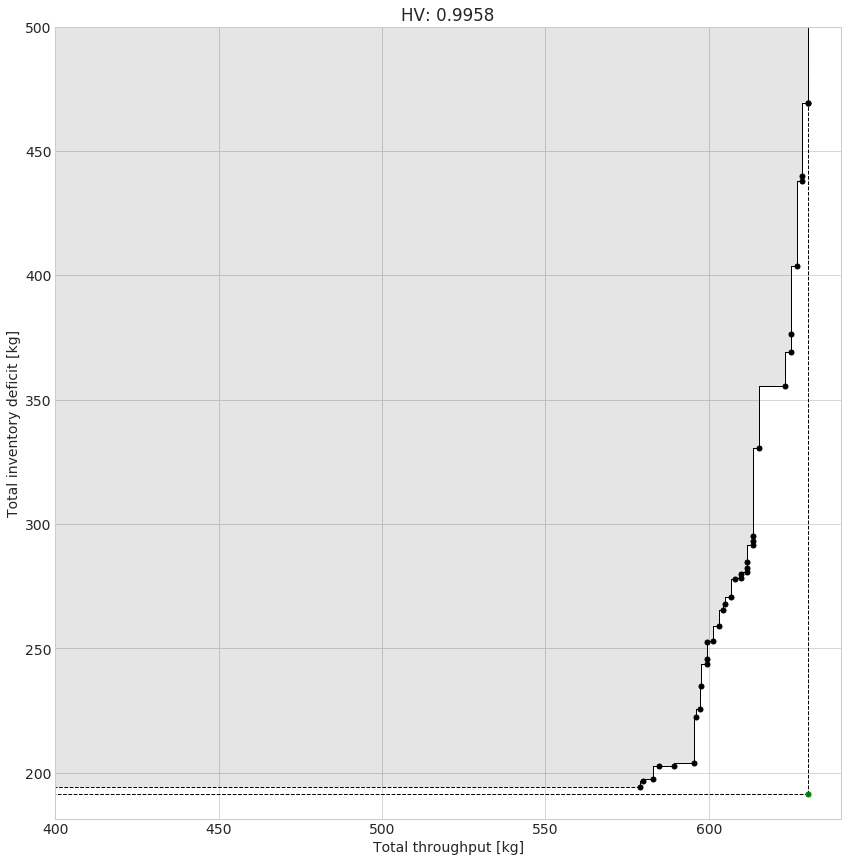

In [7]:
display(HTML('<a id="pareto_front"></a>'))
display(HTML('<h3>Pareto front</h3>'))

objective_x = 'total_kg_throughput'
objective_y = 'total_kg_inventory_deficit'

obj_x = [schedule.objectives[objective_x].values[0] for schedule in model.schedules]
obj_y = [schedule.objectives[objective_y].values[0] for schedule in model.schedules]

plt.style.use('seaborn-whitegrid')
plt.rcParams['font.size'] = 14
plt.rcParams['lines.markersize'] = 5

ref_point = [0, kg_inventory_target.sum().sum()]
ideal_point = [630.4, 191.3]

utils.plot_front(
    obj_x, 
    obj_y, 
    'Total throughput [kg]',
    'Total inventory deficit [kg]',
    figsize=(12, 12),
    ref_point=ref_point,
    ideal_point=ideal_point,
    fillcolor='black',
    fillalpha=0.1
)

hv = model.score(
    model.schedules,
    ref_point={
        'total_kg_throughput': ref_point[0],
        'total_kg_inventory_deficit': ref_point[1]
    },
    ideal_point={
        'total_kg_throughput': ideal_point[0],
        'total_kg_inventory_deficit': ideal_point[1]        
    }
)

axes = plt.gca()
axes.set_xlim([400, 10 + max(max(obj_x), ideal_point[0])])
axes.set_ylim([min(min(obj_y), ideal_point[1]) - 10, 500])
plt.tight_layout()
plt.title('HV: %.4f' % hv);
plt.savefig('figures/pareto_front.png')

display(HTML('<a href=#index>back to top</a>'))

value
total_backlog_penalty         0.0
total_cost                  773.3
total_inventory_penalty     194.4
total_kg_backlog              0.0
total_kg_inventory_deficit  194.4
total_kg_supply             449.8
total_kg_throughput         578.9
total_kg_waste                0.0
total_production_cost       578.9
total_profit               -323.5
total_revenue               449.8
total_storage_cost            0.0
total_waste_cost              0.0

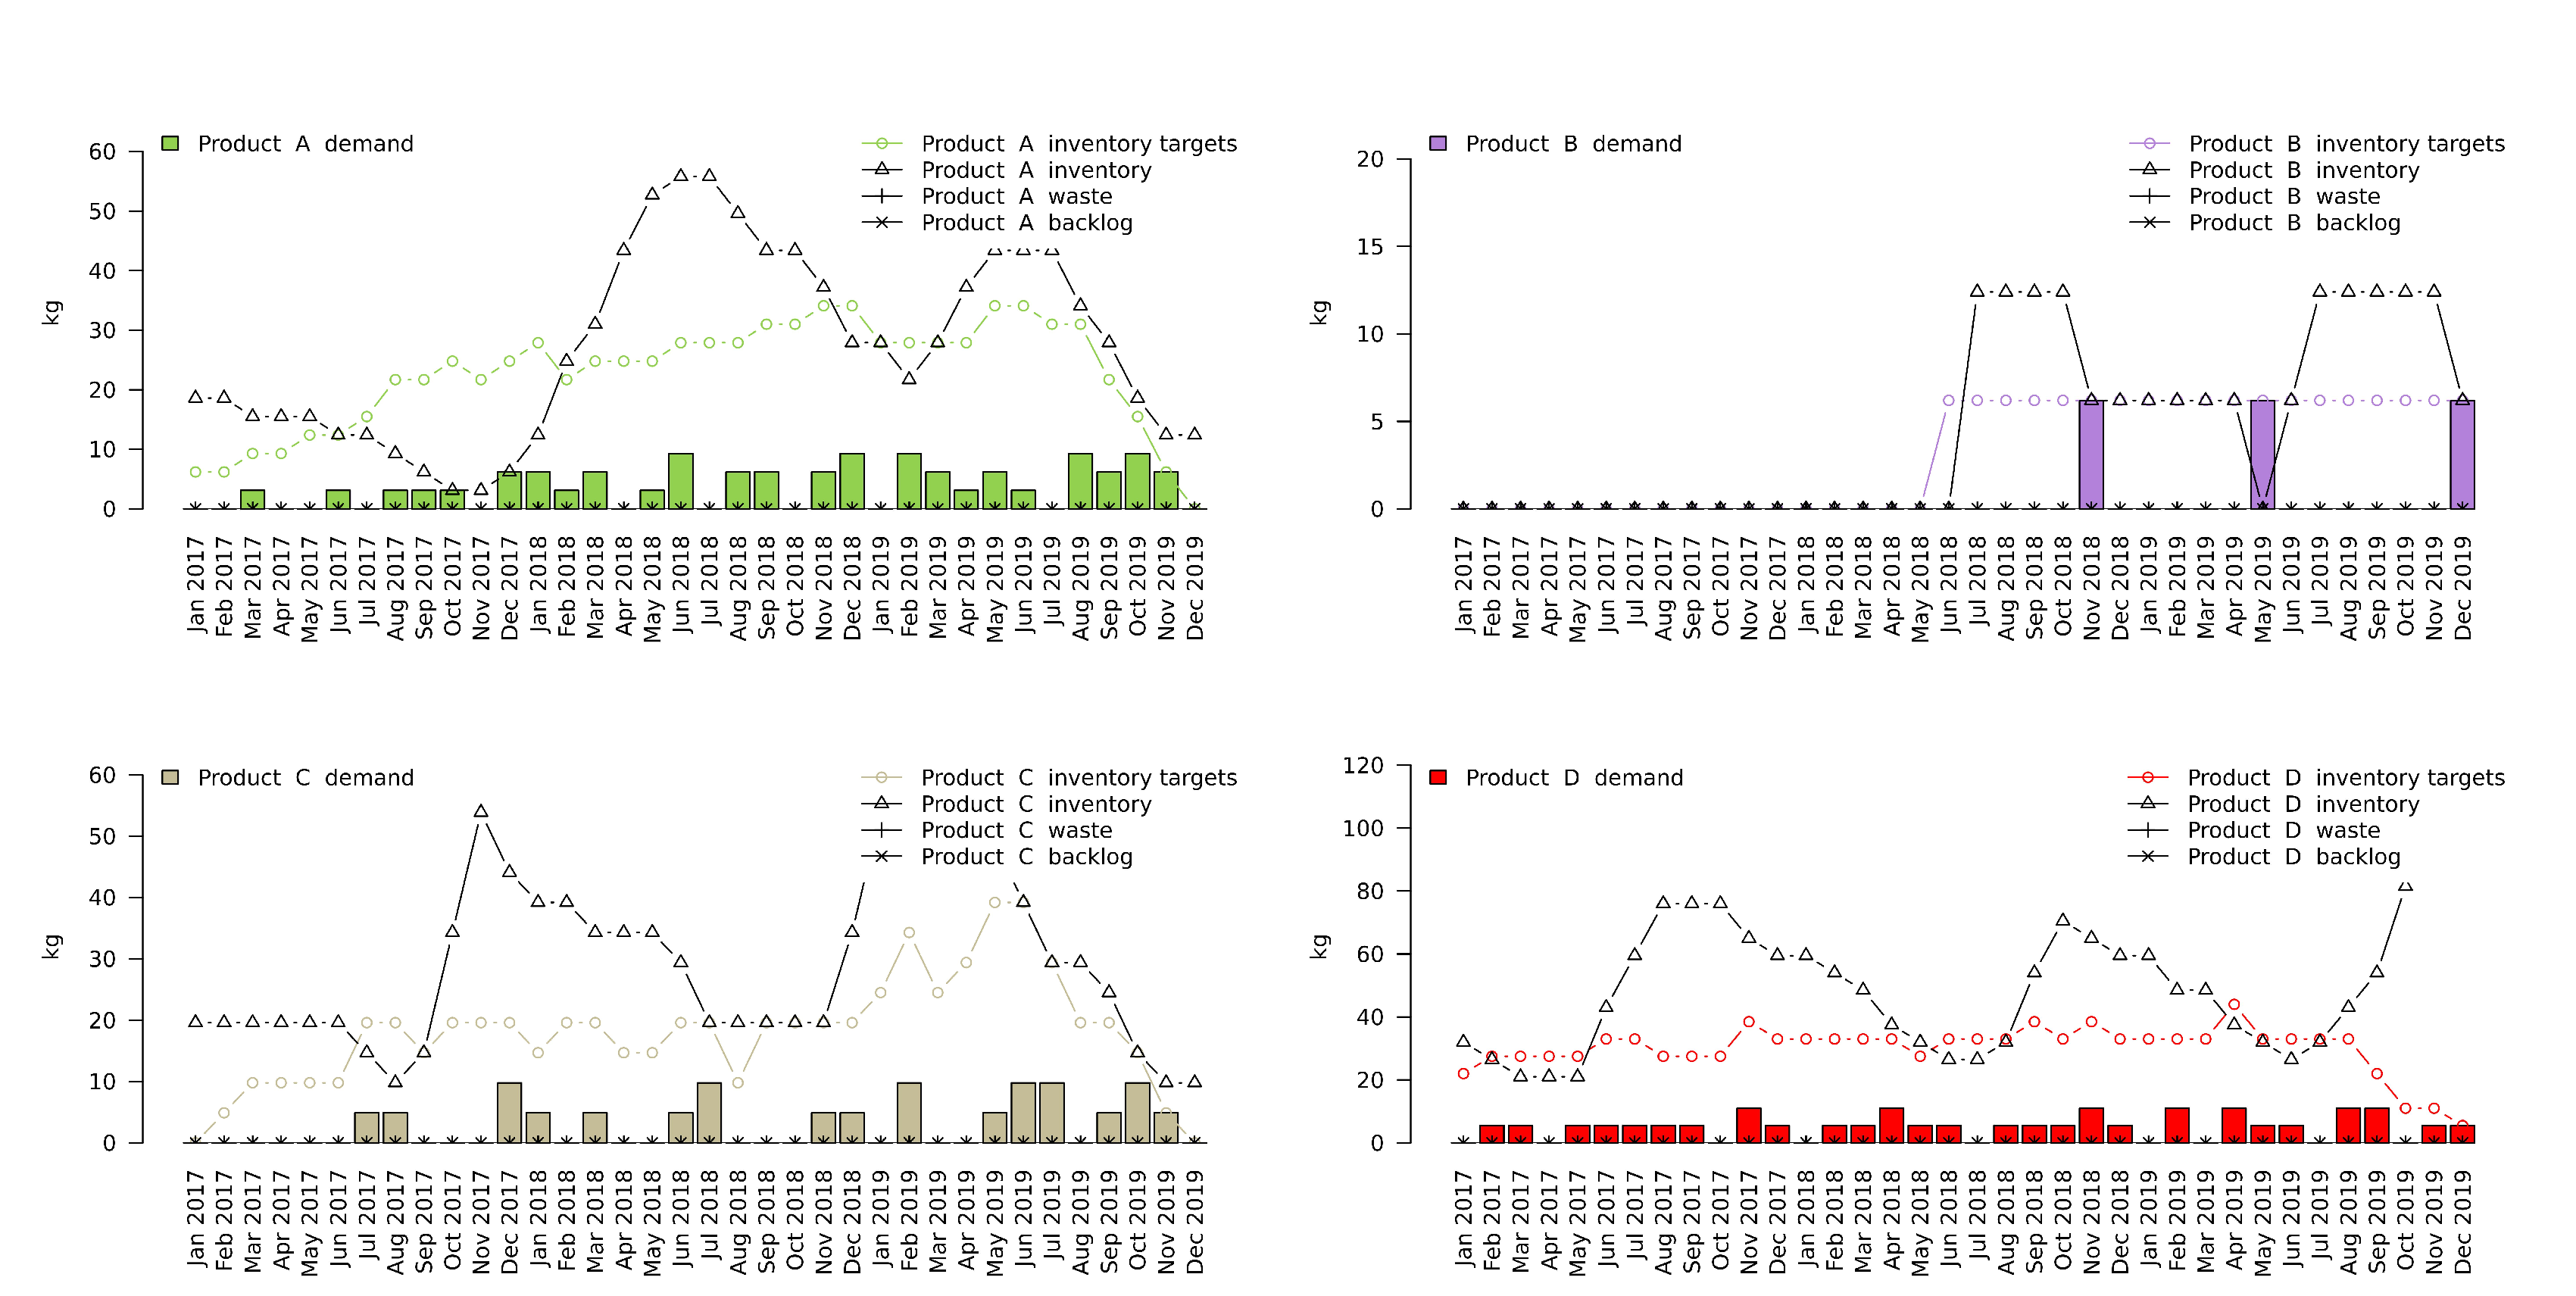

None

Product  Batches     Kg       Start First Harvest First Batch  Last Batch
0       D       15   82.5  2016-12-01    2017-01-19  2017-01-26  2017-05-04
1       C        9   44.1  2017-04-07    2017-05-22  2017-05-29  2017-07-24
2       A       28   86.8  2017-06-25    2017-08-09  2017-08-16  2018-02-21
3       B        2   12.4  2018-01-26    2018-03-03  2018-03-14  2018-03-25
4       D       12   66.0  2018-02-24    2018-04-14  2018-04-21  2018-07-07
5       C       11   53.9  2018-06-10    2018-07-25  2018-08-01  2018-10-10
6       A       14   43.4  2018-09-11    2018-10-26  2018-11-02  2019-02-01
7       B        2   12.4  2019-01-06    2019-02-11  2019-02-22  2019-03-05
8       D       30  165.0  2019-02-04    2019-03-25  2019-04-01  2019-10-21
9       B        2   12.4  2019-09-25    2019-10-31  2019-11-11  2019-11-22

Product   Kg       Start Harvested on   Stored on  Expires on Approved on
0         D  5.5  2016-12-01   2017-01-19  2017-01-26  2019-01-26  2017-04-26
1         D  5.5  2016-12-08   2017-01-26  2017-02-02  2019-02-02  2017-05-03
2         D  5.5  2016-12-15   2017-02-02  2017-02-09  2019-02-09  2017-05-10
3         D  5.5  2016-12-22   2017-02-09  2017-02-16  2019-02-16  2017-05-17
4         D  5.5  2016-12-29   2017-02-16  2017-02-23  2019-02-23  2017-05-24
5         D  5.5  2017-01-05   2017-02-23  2017-03-02  2019-03-02  2017-05-31
6         D  5.5  2017-01-12   2017-03-02  2017-03-09  2019-03-09  2017-06-07
7         D  5.5  2017-01-19   2017-03-09  2017-03-16  2019-03-16  2017-06-14
8         D  5.5  2017-01-26   2017-03-16  2017-03-23  2019-03-23  2017-06-21
9         D  5.5  2017-02-02   2017-03-23  2017-03-30  2019-03-30  2017-06-28
10        D  5.5  2017-02-09   2017-03-30  2017-04-06  2019-04-06  2017-07-05
11        D  5.5  2017-02-16   2017-04-06  2017-04-13  2019-04-13  2017-07-12
12        D  5.5  2017-02-23   2017-04-13  2017-04-20  2019-04-20  2017-07-19
13        D  5.5  2017-03-02   2017-04-20  2017-04-27  2019-04-27  2017-07-26
14        D  5.5  2017-03-09   2017-04-27  2017-05-04  2019-05-04  2017-08-02
15        C  4.9  2017-04-07   2017-05-22  2017-05-29  2019-05-29  2017-08-27
16        C  4.9  2017-04-14   2017-05-29  2017-06-05  2019-06-05  2017-09-03
17        C  4.9  2017-04-21   2017-06-05  2017-06-12  2019-06-12  2017-09-10
18        C  4.9  2017-04-28   2017-06-12  2017-06-19  2019-06-19  2017-09-17
19        C  4.9  2017-05-05   2017-06-19  2017-06-26  2019-06-26  2017-09-24
20        C  4.9  2017-05-12   2017-06-26  2017-07-03  2019-07-03  2017-10-01
21        C  4.9  2017-05-19   2017-07-03  2017-07-10  2019-07-10  2017-10-08
22        C  4.9  2017-05-26   2017-07-10  2017-07-17  2019-07-17  2017-10-15
23        C  4.9  2017-06-02   2017-07-17  2017-07-24  2019-07-24  2017-10-22
24        A  3.1  2017-06-25   2017-08-09  2017-08-16  2019-08-16  2017-11-14
25        A  3.1  2017-07-02   2017-08-16  2017-08-23  2019-08-23  2017-11-21
26        A  3.1  2017-07-09   2017-08-23  2017-08-30  2019-08-30  2017-11-28
27        A  3.1  2017-07-16   2017-08-30  2017-09-06  2019-09-06  2017-12-05
28        A  3.1  2017-07-23   2017-09-06  2017-09-13  2019-09-13  2017-12-12
29        A  3.1  2017-07-30   2017-09-13  2017-09-20  2019-09-20  2017-12-19
30        A  3.1  2017-08-06   2017-09-20  2017-09-27  2019-09-27  2017-12-26
31        A  3.1  2017-08-13   2017-09-27  2017-10-04  2019-10-04  2018-01-02
32        A  3.1  2017-08-20   2017-10-04  2017-10-11  2019-10-11  2018-01-09
33        A  3.1  2017-08-27   2017-10-11  2017-10-18  2019-10-18  2018-01-16
34        A  3.1  2017-09-03   2017-10-18  2017-10-25  2019-10-25  2018-01-23
35        A  3.1  2017-09-10   2017-10-25  2017-11-01  2019-11-01  2018-01-30
36        A  3.1  2017-09-17   2017-11-01  2017-11-08  2019-11-08  2018-02-06
37        A  3.1  2017-09-24   2017-11-08  2017-11-15  2019-11-15  2018-02-13
38        A  3.1  2017-10-01   2017-11-15  2017-11-22  2019-11-22  2018-02-20
39        A  3.1  2017-10-08   2017-11-22  2017-11-29  2019-11-29  2018-02-27
40        A  3.1  2017-10-15   2017-11-29  2017-12-06  2019-12-06  2018-03-06
41        A  3.1  2017-10-22   2017-12-06  2017-12-13  2019-12-13  2018-03-13
42        A  3.1  2017-10-29   2017-12-13  2017-12-20  2019-12-20  2018-03-20
43        A  3.1  2017-11-05   2017-12-20  2017-12-27  2019-12-27  2018-03-27
44        A  3.1  2017-11-12   2017-12-27  2018-01-03  2020-01-03  2018-04-03
45        A  3.1  2017-11-19   2018-01-03  2018-01-10  2020-01-10  2018-04-10
46        A  3.1  2017-11-26   2018-01-10  2018-01-17  2020-01-17  2018-04-17
47        A  3.1  2017-12-03   2018-01-17  2018-01-24  2020-01-24  2018-04-24
48        A  3.1  2017-12-10   2018-01-24  2018-01-31  2020-01-31  2018-05-01
49        A  3.1  2017-12-17   2018-01-31  2018-02-07  2020-02-07  2018-05-08
50        A  3.1  2017-12-

None

Product         Task       Start      Finish
0         D  Inoculation  2016-12-01  2016-12-27
1         D         Seed  2016-12-27  2017-01-05
2         D   Production  2017-01-05  2017-01-19
3         D          DSP  2017-01-19  2017-01-26
4         D  Inoculation  2016-12-08  2017-01-03
5         D         Seed  2017-01-03  2017-01-12
6         D   Production  2017-01-12  2017-01-26
7         D          DSP  2017-01-26  2017-02-02
8         D  Inoculation  2016-12-15  2017-01-10
9         D         Seed  2017-01-10  2017-01-19
10        D   Production  2017-01-19  2017-02-02
11        D          DSP  2017-02-02  2017-02-09
12        D  Inoculation  2016-12-22  2017-01-17
13        D         Seed  2017-01-17  2017-01-26
14        D   Production  2017-01-26  2017-02-09
15        D          DSP  2017-02-09  2017-02-16
16        D  Inoculation  2016-12-29  2017-01-24
17        D         Seed  2017-01-24  2017-02-02
18        D   Production  2017-02-02  2017-02-16
19        D          DSP  2017-02-16  2017-02-23
20        D  Inoculation  2017-01-05  2017-01-31
21        D         Seed  2017-01-31  2017-02-09
22        D   Production  2017-02-09  2017-02-23
23        D          DSP  2017-02-23  2017-03-02
24        D  Inoculation  2017-01-12  2017-02-07
25        D         Seed  2017-02-07  2017-02-16
26        D   Production  2017-02-16  2017-03-02
27        D          DSP  2017-03-02  2017-03-09
28        D  Inoculation  2017-01-19  2017-02-14
29        D         Seed  2017-02-14  2017-02-23
30        D   Production  2017-02-23  2017-03-09
31        D          DSP  2017-03-09  2017-03-16
32        D  Inoculation  2017-01-26  2017-02-21
33        D         Seed  2017-02-21  2017-03-02
34        D   Production  2017-03-02  2017-03-16
35        D          DSP  2017-03-16  2017-03-23
36        D  Inoculation  2017-02-02  2017-02-28
37        D         Seed  2017-02-28  2017-03-09
38        D   Production  2017-03-09  2017-03-23
39        D          DSP  2017-03-23  2017-03-30
40        D  Inoculation  2017-02-09  2017-03-07
41        D         Seed  2017-03-07  2017-03-16
42        D   Production  2017-03-16  2017-03-30
43        D          DSP  2017-03-30  2017-04-06
44        D  Inoculation  2017-02-16  2017-03-14
45        D         Seed  2017-03-14  2017-03-23
46        D   Production  2017-03-23  2017-04-06
47        D          DSP  2017-04-06  2017-04-13
48        D  Inoculation  2017-02-23  2017-03-21
49        D         Seed  2017-03-21  2017-03-30
50        D   Production  2017-03-30  2017-04-13
51        D          DSP  2017-04-13  2017-04-20
52        D  Inoculation  2017-03-02  2017-03-28
53        D         Seed  2017-03-28  2017-04-06
54        D   Production  2017-04-06  2017-04-20
55        D          DSP  2017-04-20  2017-04-27
56        D  Inoculation  2017-03-09  2017-04-04
57        D         Seed  2017-04-04  2017-04-13
58        D   Production  2017-04-13  2017-04-27
59        D          DSP  2017-04-27  2017-05-04
60        C  Inoculation  2017-04-07  2017-04-27
61        C         Seed  2017-04-27  2017-05-08
62        C   Production  2017-05-08  2017-05-22
63        C          DSP  2017-05-22  2017-05-29
64        C  Inoculation  2017-04-14  2017-05-04
65        C         Seed  2017-05-04  2017-05-15
66        C   Production  2017-05-15  2017-05-29
67        C          DSP  2017-05-29  2017-06-05
68        C  Inoculation  2017-04-21  2017-05-11
69        C         Seed  2017-05-11  2017-05-22
70        C   Production  2017-05-22  2017-06-05
71        C          DSP  2017-06-05  2017-06-12
72        C  Inoculation  2017-04-28  2017-05-18
73        C         Seed  2017-05-18  2017-05-29
74        C   Production  2017-05-29  2017-06-12
75        C          DSP  2017-06-12  2017-06-19
76        C  Inoculation  2017-05-05  2017-05-25
77        C         Seed  2017-05-25  2017-06-05
78        C   Production  2017-06-05  2017-06-19
79        C          DSP  2017-06-19  2017-06-26
80        C  Inoculation  2017-05-1

In [10]:
i = np.argmin(obj_x)

display(HTML('<a id="solution_x"></a>'))
display(HTML('<h3>Solution X</h3>'))
display(HTML('<a href=#index>back to top</a>'))

display(HTML('<a id="objectives"></a>'))
display(HTML('<h4>Objectives</h4>'))
display(model.schedules[i].objectives.transpose())
display(HTML('<a href=#index>back to top</a>'))

display(HTML('<a id="inventory"></a>'))
display(HTML('<h4>Inventory levels</h4>'))
display(HTML('<p>Kg inventory after demand and waste have been accounted for.</p>'))
utils.product_profiles(i, model)
display(HTML('<a href=#index>back to top</a>'))

display(HTML('<a id="campaigns_gantt"></a>'))
display(HTML('<h4>Campaigns gantt</h4>'))
display(model.schedules[i].campaigns_gantt(colors))
display(HTML('<a href=#index>back to top</a>'))

display(HTML('<a id="campaigns_table"></a>'))
display(HTML('<h4>Campaigns table</h4>'))
display(model.schedules[i].campaigns)
display(HTML('<a href=#index>back to top</a>'))

display(HTML('<a id="batches_table"></a>'))
display(HTML('<h4>Bathces table</h4>'))
display(model.schedules[i].batches)       
display(HTML('<a href=#index>back to top</a>'))

display(HTML('<a id="tasks_gantt"></a>'))
display(HTML('<h4>Tasks gantt</h4>'))
display(model.schedules[i].tasks_gantt(colors))   
display(HTML('<a href=#index>back to top</a>'))

display(HTML('<a id="tasks_table"></a>'))
display(HTML('<h4>Tasks table</h4>'))
display(model.schedules[i].tasks)    
display(HTML('<a href=#index>back to top</a>'))

value
total_backlog_penalty          0.0
total_cost                  1099.7
total_inventory_penalty      469.3
total_kg_backlog               0.0
total_kg_inventory_deficit   469.3
total_kg_supply              449.8
total_kg_throughput          630.4
total_kg_waste                 0.0
total_production_cost        630.4
total_profit                -649.9
total_revenue                449.8
total_storage_cost             0.0
total_waste_cost               0.0

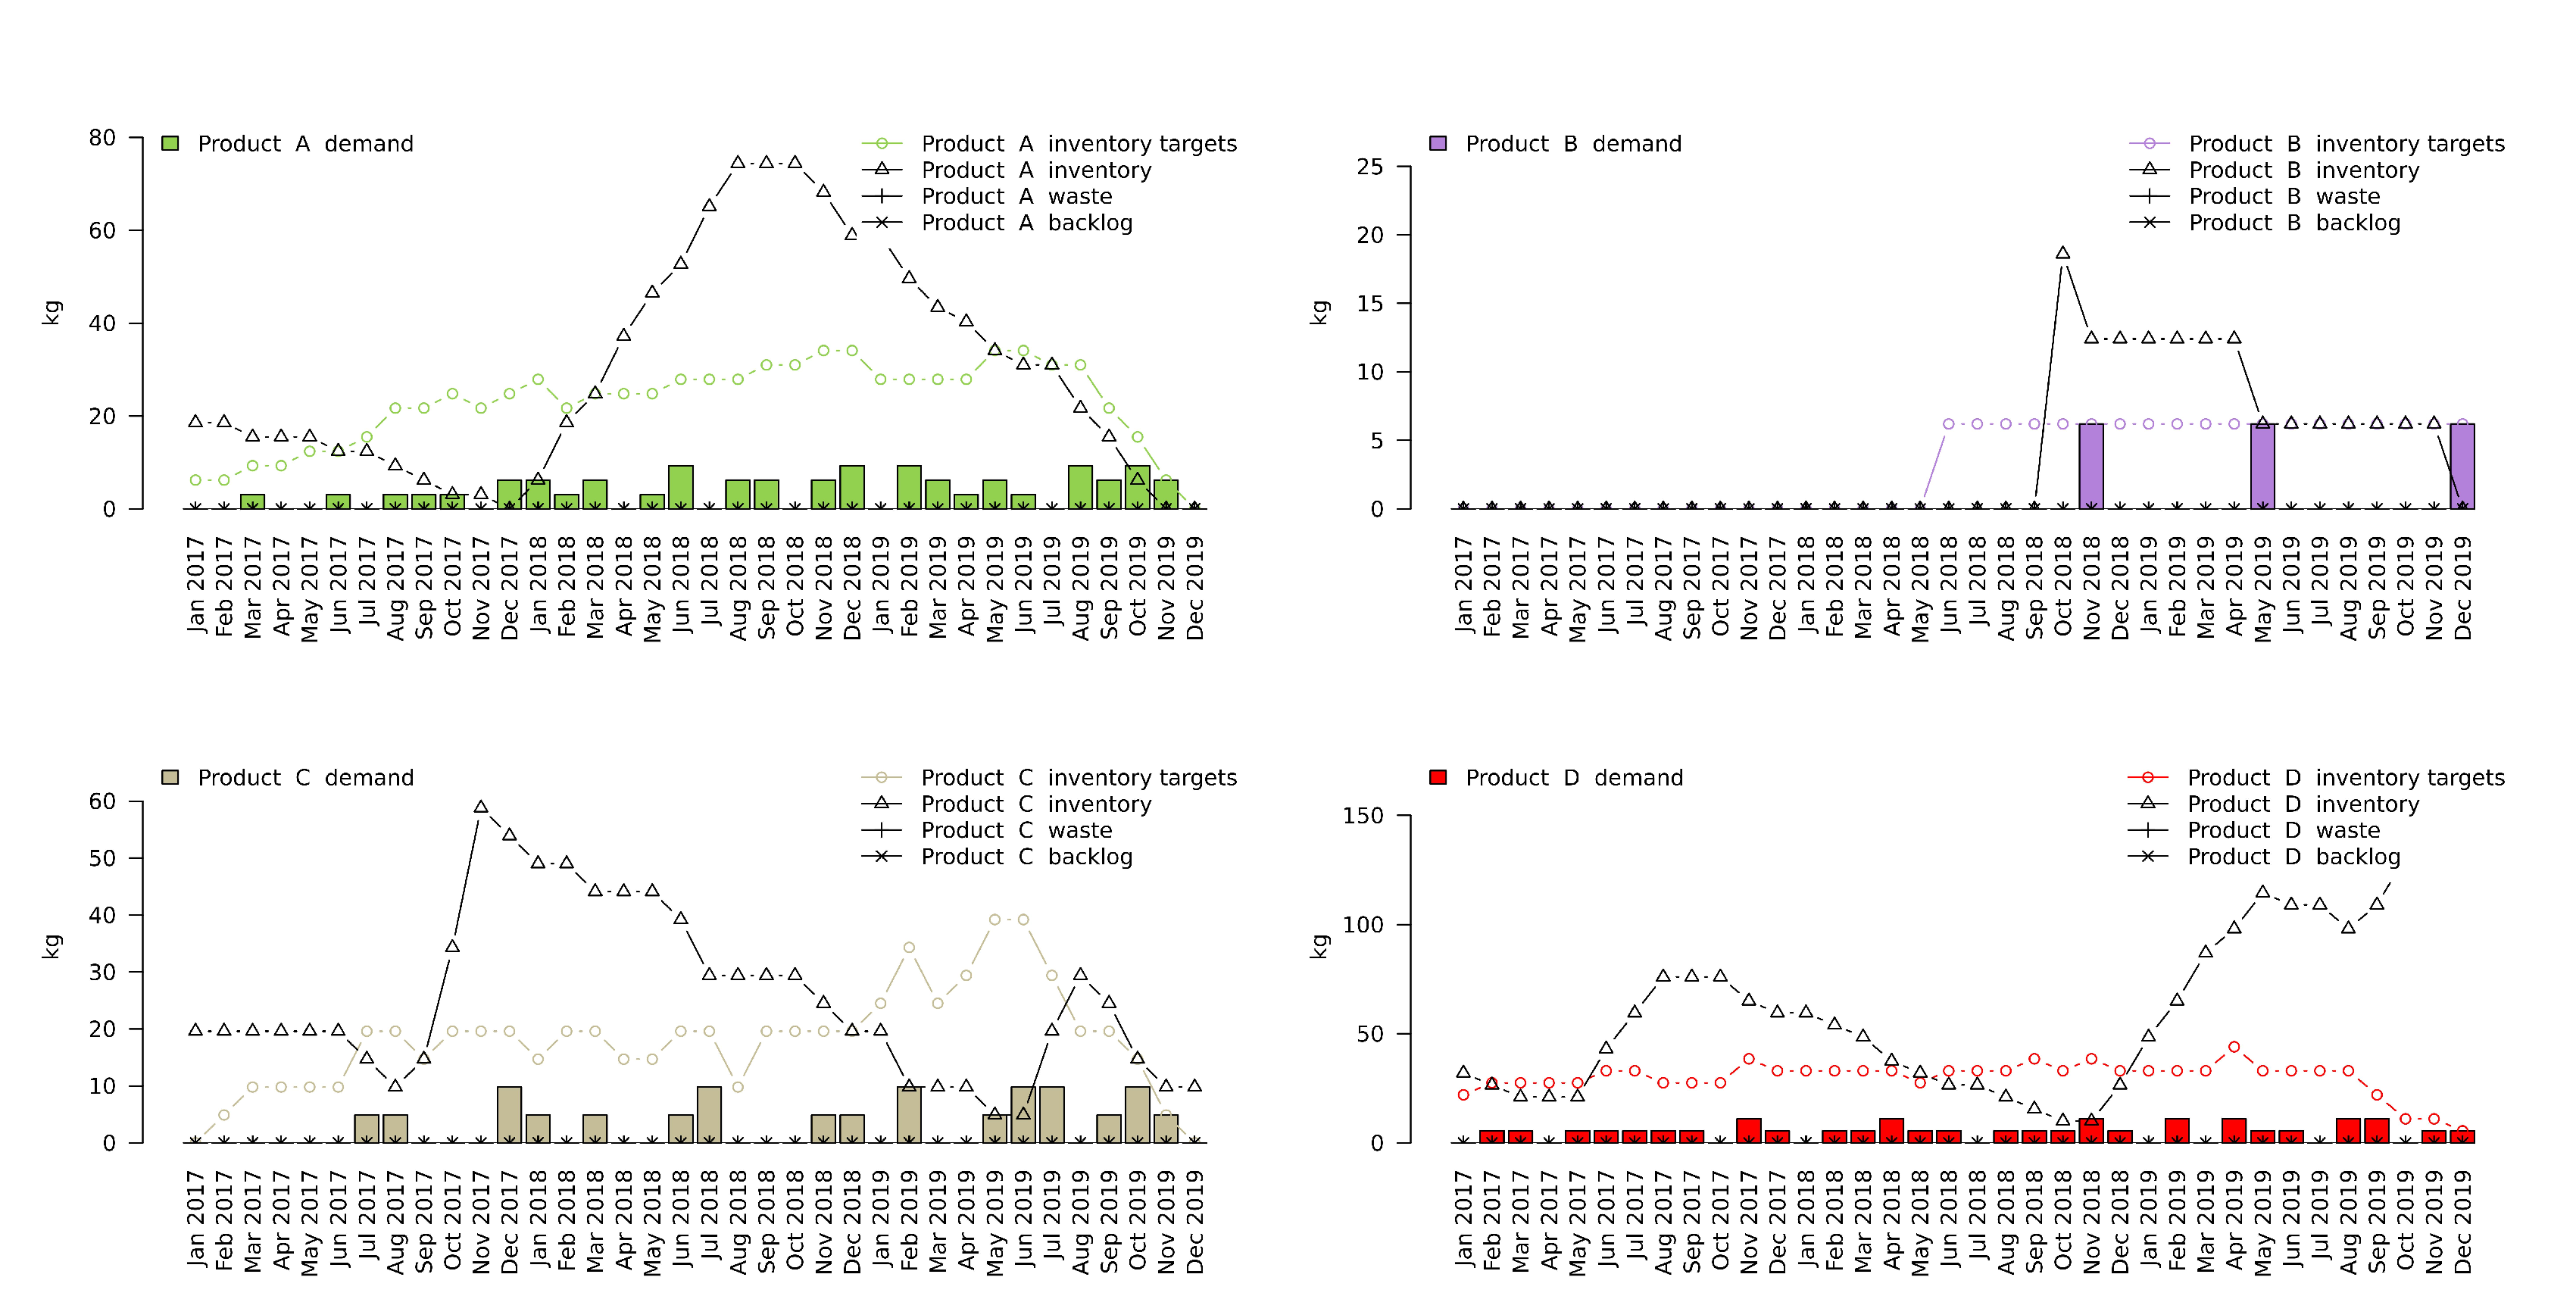

None

Product  Batches     Kg       Start First Harvest First Batch  Last Batch
0       D       15   82.5  2016-12-01    2017-01-19  2017-01-26  2017-05-04
1       C       11   53.9  2017-04-07    2017-05-22  2017-05-29  2017-08-07
2       A       38  117.8  2017-07-09    2017-08-23  2017-08-30  2018-05-16
3       B        3   18.6  2018-04-20    2018-05-26  2018-06-06  2018-06-28
4       D       27  148.5  2018-05-30    2018-07-18  2018-07-25  2019-01-23
5       C        9   44.1  2018-12-27    2019-02-10  2019-02-17  2019-04-14
6       D       30  165.0  2019-03-16    2019-05-04  2019-05-11  2019-11-30

Product   Kg       Start Harvested on   Stored on  Expires on Approved on
0         D  5.5  2016-12-01   2017-01-19  2017-01-26  2019-01-26  2017-04-26
1         D  5.5  2016-12-08   2017-01-26  2017-02-02  2019-02-02  2017-05-03
2         D  5.5  2016-12-15   2017-02-02  2017-02-09  2019-02-09  2017-05-10
3         D  5.5  2016-12-22   2017-02-09  2017-02-16  2019-02-16  2017-05-17
4         D  5.5  2016-12-29   2017-02-16  2017-02-23  2019-02-23  2017-05-24
5         D  5.5  2017-01-05   2017-02-23  2017-03-02  2019-03-02  2017-05-31
6         D  5.5  2017-01-12   2017-03-02  2017-03-09  2019-03-09  2017-06-07
7         D  5.5  2017-01-19   2017-03-09  2017-03-16  2019-03-16  2017-06-14
8         D  5.5  2017-01-26   2017-03-16  2017-03-23  2019-03-23  2017-06-21
9         D  5.5  2017-02-02   2017-03-23  2017-03-30  2019-03-30  2017-06-28
10        D  5.5  2017-02-09   2017-03-30  2017-04-06  2019-04-06  2017-07-05
11        D  5.5  2017-02-16   2017-04-06  2017-04-13  2019-04-13  2017-07-12
12        D  5.5  2017-02-23   2017-04-13  2017-04-20  2019-04-20  2017-07-19
13        D  5.5  2017-03-02   2017-04-20  2017-04-27  2019-04-27  2017-07-26
14        D  5.5  2017-03-09   2017-04-27  2017-05-04  2019-05-04  2017-08-02
15        C  4.9  2017-04-07   2017-05-22  2017-05-29  2019-05-29  2017-08-27
16        C  4.9  2017-04-14   2017-05-29  2017-06-05  2019-06-05  2017-09-03
17        C  4.9  2017-04-21   2017-06-05  2017-06-12  2019-06-12  2017-09-10
18        C  4.9  2017-04-28   2017-06-12  2017-06-19  2019-06-19  2017-09-17
19        C  4.9  2017-05-05   2017-06-19  2017-06-26  2019-06-26  2017-09-24
20        C  4.9  2017-05-12   2017-06-26  2017-07-03  2019-07-03  2017-10-01
21        C  4.9  2017-05-19   2017-07-03  2017-07-10  2019-07-10  2017-10-08
22        C  4.9  2017-05-26   2017-07-10  2017-07-17  2019-07-17  2017-10-15
23        C  4.9  2017-06-02   2017-07-17  2017-07-24  2019-07-24  2017-10-22
24        C  4.9  2017-06-09   2017-07-24  2017-07-31  2019-07-31  2017-10-29
25        C  4.9  2017-06-16   2017-07-31  2017-08-07  2019-08-07  2017-11-05
26        A  3.1  2017-07-09   2017-08-23  2017-08-30  2019-08-30  2017-11-28
27        A  3.1  2017-07-16   2017-08-30  2017-09-06  2019-09-06  2017-12-05
28        A  3.1  2017-07-23   2017-09-06  2017-09-13  2019-09-13  2017-12-12
29        A  3.1  2017-07-30   2017-09-13  2017-09-20  2019-09-20  2017-12-19
30        A  3.1  2017-08-06   2017-09-20  2017-09-27  2019-09-27  2017-12-26
31        A  3.1  2017-08-13   2017-09-27  2017-10-04  2019-10-04  2018-01-02
32        A  3.1  2017-08-20   2017-10-04  2017-10-11  2019-10-11  2018-01-09
33        A  3.1  2017-08-27   2017-10-11  2017-10-18  2019-10-18  2018-01-16
34        A  3.1  2017-09-03   2017-10-18  2017-10-25  2019-10-25  2018-01-23
35        A  3.1  2017-09-10   2017-10-25  2017-11-01  2019-11-01  2018-01-30
36        A  3.1  2017-09-17   2017-11-01  2017-11-08  2019-11-08  2018-02-06
37        A  3.1  2017-09-24   2017-11-08  2017-11-15  2019-11-15  2018-02-13
38        A  3.1  2017-10-01   2017-11-15  2017-11-22  2019-11-22  2018-02-20
39        A  3.1  2017-10-08   2017-11-22  2017-11-29  2019-11-29  2018-02-27
40        A  3.1  2017-10-15   2017-11-29  2017-12-06  2019-12-06  2018-03-06
41        A  3.1  2017-10-22   2017-12-06  2017-12-13  2019-12-13  2018-03-13
42        A  3.1  2017-10-29   2017-12-13  2017-12-20  2019-12-20  2018-03-20
43        A  3.1  2017-11-05   2017-12-20  2017-12-27  2019-12-27  2018-03-27
44        A  3.1  2017-11-12   2017-12-27  2018-01-03  2020-01-03  2018-04-03
45        A  3.1  2017-11-19   2018-01-03  2018-01-10  2020-01-10  2018-04-10
46        A  3.1  2017-11-26   2018-01-10  2018-01-17  2020-01-17  2018-04-17
47        A  3.1  2017-12-03   2018-01-17  2018-01-24  2020-01-24  2018-04-24
48        A  3.1  2017-12-10   2018-01-24  2018-01-31  2020-01-31  2018-05-01
49        A  3.1  2017-12-17   2018-01-31  2018-02-07  2020-02-07  2018-05-08
50        A  3.1  2017-12-

None

Product         Task       Start      Finish
0         D  Inoculation  2016-12-01  2016-12-27
1         D         Seed  2016-12-27  2017-01-05
2         D   Production  2017-01-05  2017-01-19
3         D          DSP  2017-01-19  2017-01-26
4         D  Inoculation  2016-12-08  2017-01-03
5         D         Seed  2017-01-03  2017-01-12
6         D   Production  2017-01-12  2017-01-26
7         D          DSP  2017-01-26  2017-02-02
8         D  Inoculation  2016-12-15  2017-01-10
9         D         Seed  2017-01-10  2017-01-19
10        D   Production  2017-01-19  2017-02-02
11        D          DSP  2017-02-02  2017-02-09
12        D  Inoculation  2016-12-22  2017-01-17
13        D         Seed  2017-01-17  2017-01-26
14        D   Production  2017-01-26  2017-02-09
15        D          DSP  2017-02-09  2017-02-16
16        D  Inoculation  2016-12-29  2017-01-24
17        D         Seed  2017-01-24  2017-02-02
18        D   Production  2017-02-02  2017-02-16
19        D          DSP  2017-02-16  2017-02-23
20        D  Inoculation  2017-01-05  2017-01-31
21        D         Seed  2017-01-31  2017-02-09
22        D   Production  2017-02-09  2017-02-23
23        D          DSP  2017-02-23  2017-03-02
24        D  Inoculation  2017-01-12  2017-02-07
25        D         Seed  2017-02-07  2017-02-16
26        D   Production  2017-02-16  2017-03-02
27        D          DSP  2017-03-02  2017-03-09
28        D  Inoculation  2017-01-19  2017-02-14
29        D         Seed  2017-02-14  2017-02-23
30        D   Production  2017-02-23  2017-03-09
31        D          DSP  2017-03-09  2017-03-16
32        D  Inoculation  2017-01-26  2017-02-21
33        D         Seed  2017-02-21  2017-03-02
34        D   Production  2017-03-02  2017-03-16
35        D          DSP  2017-03-16  2017-03-23
36        D  Inoculation  2017-02-02  2017-02-28
37        D         Seed  2017-02-28  2017-03-09
38        D   Production  2017-03-09  2017-03-23
39        D          DSP  2017-03-23  2017-03-30
40        D  Inoculation  2017-02-09  2017-03-07
41        D         Seed  2017-03-07  2017-03-16
42        D   Production  2017-03-16  2017-03-30
43        D          DSP  2017-03-30  2017-04-06
44        D  Inoculation  2017-02-16  2017-03-14
45        D         Seed  2017-03-14  2017-03-23
46        D   Production  2017-03-23  2017-04-06
47        D          DSP  2017-04-06  2017-04-13
48        D  Inoculation  2017-02-23  2017-03-21
49        D         Seed  2017-03-21  2017-03-30
50        D   Production  2017-03-30  2017-04-13
51        D          DSP  2017-04-13  2017-04-20
52        D  Inoculation  2017-03-02  2017-03-28
53        D         Seed  2017-03-28  2017-04-06
54        D   Production  2017-04-06  2017-04-20
55        D          DSP  2017-04-20  2017-04-27
56        D  Inoculation  2017-03-09  2017-04-04
57        D         Seed  2017-04-04  2017-04-13
58        D   Production  2017-04-13  2017-04-27
59        D          DSP  2017-04-27  2017-05-04
60        C  Inoculation  2017-04-07  2017-04-27
61        C         Seed  2017-04-27  2017-05-08
62        C   Production  2017-05-08  2017-05-22
63        C          DSP  2017-05-22  2017-05-29
64        C  Inoculation  2017-04-14  2017-05-04
65        C         Seed  2017-05-04  2017-05-15
66        C   Production  2017-05-15  2017-05-29
67        C          DSP  2017-05-29  2017-06-05
68        C  Inoculation  2017-04-21  2017-05-11
69        C         Seed  2017-05-11  2017-05-22
70        C   Production  2017-05-22  2017-06-05
71        C          DSP  2017-06-05  2017-06-12
72        C  Inoculation  2017-04-28  2017-05-18
73        C         Seed  2017-05-18  2017-05-29
74        C   Production  2017-05-29  2017-06-12
75        C          DSP  2017-06-12  2017-06-19
76        C  Inoculation  2017-05-05  2017-05-25
77        C         Seed  2017-05-25  2017-06-05
78        C   Production  2017-06-05  2017-06-19
79        C          DSP  2017-06-19  2017-06-26
80        C  Inoculation  2017-05-1

In [9]:
i = np.argmax(obj_x)

display(HTML('<a id="solution_y"></a>'))
display(HTML('<h3>Solution Y</h3>'))
display(HTML('<a href=#index>back to top</a>'))

display(HTML('<a id="objectives_y"></a>'))
display(HTML('<h4>Objectives</h4>'))
display(model.schedules[i].objectives.transpose())
display(HTML('<a href=#index>back to top</a>'))

display(HTML('<a id="inventory_y"></a>'))
display(HTML('<h4>Inventory levels</h4>'))
display(HTML('<p>Kg inventory after demand and waste have been accounted for.</p>'))
utils.product_profiles(i, model)
display(HTML('<a href=#index>back to top</a>'))

display(HTML('<a id="campaigns_gantt_y"></a>'))
display(HTML('<h4>Campaigns gantt</h4>'))
display(model.schedules[i].campaigns_gantt(colors))
display(HTML('<a href=#index>back to top</a>'))

display(HTML('<a id="campaigns_table_y"></a>'))
display(HTML('<h4>Campaigns table</h4>'))
display(model.schedules[i].campaigns)
display(HTML('<a href=#index>back to top</a>'))

display(HTML('<a id="batches_table_y"></a>'))
display(HTML('<h4>Bathces table</h4>'))
display(model.schedules[i].batches)       
display(HTML('<a href=#index>back to top</a>'))

display(HTML('<a id="tasks_gantt_y"></a>'))
display(HTML('<h4>Tasks gantt</h4>'))
display(model.schedules[i].tasks_gantt(colors))   
display(HTML('<a href=#index>back to top</a>'))

display(HTML('<a id="tasks_table_y"></a>'))
display(HTML('<h4>Tasks table</h4>'))
display(model.schedules[i].tasks)    
display(HTML('<a href=#index>back to top</a>'))